# Mammography data and TNBC outcomes
This notebook is used to investigate the relationship between TNBC outcomes and estimatied breast density and spiculation (mammo mass margin). Both estimates where done on a 1-4 scale.

In [46]:
import seaborn as sns
import pandas as pd
import numpy as np

# Import data
df = pd.read_excel("../data/TNBC.xlsx")

# Only keep some columns
df = df[[
    "Mammo Mass margin",
    "Breast density",
    "distant_relapse",
    "local_relapse",
    "OS"
]]

# Rename some stuff
df = df.replace(99, np.NaN)
df = df.replace("A", 1)
df = df.replace("B", 2)
df = df.replace("C", 3)
df = df.replace("D", 4)
df = df.dropna()
df = df.astype(float)

outcomes = ["distant_relapse", "local_relapse", "OS"] 
df[outcomes] = df[outcomes].astype(bool)

## Student's t-test
To see whether there's any differece in distribution of the estimates among those with a certain outcome (distant relapse, local relapse and overall survival) we divide and the cohort for an outcome and run a t-test for each estimate. This leads to a total of 6 tests (3 outcomes x 2 estimates).

A t-test can be used to deremine how likely a differnce in mean of two sets is due to chance. A low p-value indicates that it's unlikely that estimate difference between two groups was due to chance.    

We should be somewhat sceptical of this result since we apply this test to six different pairs. We will expect a low p-value result to show up due to randomness alone every now and then.

In [47]:
from scipy.stats import ttest_ind

res = []
outcomes = ["distant_relapse", "local_relapse", "OS"] 
features = set(df.columns) - set(outcomes)

for outcome in outcomes:
    a = df[df[outcome] == 1]
    b = df[df[outcome] == 0]

    for feature in features:
        if feature == outcome:
            continue
        
        t_stat, p_value = ttest_ind(a[feature], b[feature])
        res.append({
            "t_stat" : t_stat,
            "feature" : feature,
            "p_value" : p_value,
            "outcome" : outcome
        })
        
df_ttest = pd.DataFrame(res).sort_values("p_value").reset_index()
df_ttest

,index,t_stat,feature,p_value,outcome
0,1,-2.112608,Breast density,0.035622,distant_relapse
1,5,2.006764,Breast density,0.045847,OS
2,0,-1.668491,Mammo Mass margin,0.096465,distant_relapse
3,3,1.593685,Breast density,0.112265,local_relapse
4,2,0.253484,Mammo Mass margin,0.800102,local_relapse
5,4,0.090515,Mammo Mass margin,0.927950,OS


From the table above breast density seems to be correlated with distant relapse since the p-value is low. The same goes for breast density and overall survival. This is expected since OS and distant relapse have a large negative correlation. (Note the difference in the sign of the t-stat.)

([<matplotlib.axis.XTick at 0x7fbbaeefe5b0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

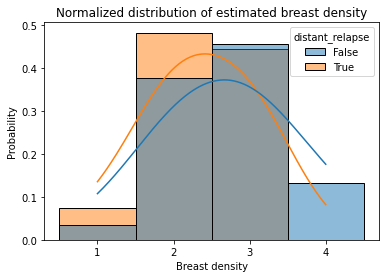

In [142]:
import matplotlib.pyplot as plt

sns.histplot(data=df, x = "Breast density",
             hue = "distant_relapse",
             discrete=True,
             stat="probability",
             common_norm=False,
             kde=True, 
             kde_kws = {"bw_method":1})
plt.title("Normalized distribution of estimated breast density")
plt.xticks([1,2,3,4])

By plotting the the breast density estimates as a histogram we can illustrate the difference in distribution between the two groups (those with and without distant relapse). Note that the y-axis denotes probability and not count.

A gaussian kernel is used to estimate the distribution (the two lines). From this we can see that low breast densiy seems to give a slight indication of developing distant relapse.

Better estimates and larger cohort could help us cement this hypothesis.